In [1]:
import torch
import torch.nn as nn

from load_model import load_model
from load_data import load_data

import sklearn as sk
import sklearn.linear_model as skl
import sklearn.metrics as skm
import sklearn.decomposition as skd

import numpy as np

import data
from tqdm import tqdm

import scipy.stats as stats

import matplotlib as mpl
import matplotlib.pyplot as plt

import argparse

import utils

import os

import seaborn as sns
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
forget_gates = np.load('generated_files/forget_gates.npy').item()
input_gates = np.load('generated_files/input_gates.npy').item()
output_gates = np.load('generated_files/output_gates.npy').item()
cell_states = np.load('generated_files/cell_gates.npy').item()
hidden_states = np.load('generated_files/hidden_gates.npy').item()

In [4]:
sentences,labels = load_data('dahaene_dataset/filtered_sentences.txt','open_nodes')

In [143]:
def classifier_finder(gates,targets,penalization=[0.001,0.01,0.1,1,10,100],train_percent=[0.2,0.4,0.6,0.8],krnl='linear',weights='balanced'):
    clsfrs = []
    for prct in train_percent:
        print('Training Percent',prct)
        
        positive_indices = np.where(targets==1)[0]
        negative_indices = np.where(targets==0)[0]
        
        pos_train_indices = np.random.choice(positive_indices,int(prct*len(positive_indices)),replace=False)
        pos_test_indices = np.array(list(set(positive_indices).difference(pos_train_indices)))
        
        neg_train_indices = np.random.choice(negative_indices,int(prct*len(negative_indices)),replace=False)
        neg_test_indices = np.array(list(set(negative_indices).difference(neg_train_indices)))
        
        train_indices = np.concatenate((pos_train_indices,neg_train_indices))
        test_indices = np.concatenate((pos_test_indices,neg_test_indices))
        
        X_train = gates[train_indices,:]
        y_train = targets[train_indices]
        
        X_test = gates[test_indices,:]
        y_test = targets[test_indices]
        
        for pen in penalization:
            print('C',pen)
            csf = sk.svm.SVC(C=pen,kernel=krnl,class_weight=weights)
            csf.fit(X_train,y_train)
            
            print('Acc',csf.score(X_test,y_test))
            
            clsfrs.append((csf,X_train,y_train,X_test,y_test))
    
    return clsfrs
        
        
            
    

In [106]:
def regressor_finder(gates,targets,class_targets,penalization=[0.001,0.01,0.1,1,10,100],train_percent=[0.2,0.4,0.6,0.8]):
    rgrsrs = []
    for prct in train_percent:
        print('Training Percent',prct)
        
        positive_indices = np.where(class_targets==1)[0]
        negative_indices = np.where(class_targets==0)[0]
        
        pos_train_indices = np.random.choice(positive_indices,int(prct*len(positive_indices)),replace=False)
        pos_test_indices = np.array(list(set(positive_indices).difference(pos_train_indices)))
        
        neg_train_indices = np.random.choice(negative_indices,int(prct*len(negative_indices)),replace=False)
        neg_test_indices = np.array(list(set(negative_indices).difference(neg_train_indices)))
        
        train_indices = np.concatenate((pos_train_indices,neg_train_indices))
        test_indices = np.concatenate((pos_test_indices,neg_test_indices))
        
        X_train = gates[train_indices,:]
        y_train = targets[train_indices]
        
        X_test = gates[test_indices,:]
        y_test = targets[test_indices]
        
        for pen in penalization:
            print('C',pen)
            csf = skl.Ridge(alpha=pen)
            csf.fit(X_train,y_train)
            
            print('R^2',csf.score(X_test,y_test))
            
            rgrsrs.append((csf,X_train,y_train,X_test,y_test))
    
    return rgrsrs

In [107]:
def get_class_targets(gates, offset=0):
    
    targets = {}
    
    # iterate over all layers in the gates in question
    for lyr in gates.keys():
            
        merge_target = []
        merge_train = []
        
        # iterate over all sentences
        for sidx, sentence in enumerate(sentences):
            previous_label = 0
            for lidx, label in enumerate(labels[sidx]):
                
                # merge happens when the label stays the same or decreases
                if label <= previous_label:
                    merge_target.append(1)
                else:
                    merge_target.append(0)
                    
                merge_train.append(gates[lyr][sidx][lidx])
                previous_label = label
        
        
        # if offset is 0 our X are the words after the merge
        # if offset is -1 our X are the words right before the merge
        if offset <= 0:
            merge_target = merge_target[-offset:]+[0]*(-offset)
        else:
            merge_target = [0]*(offset)+merge_target[:len(merge_target)-offset]
        
        targets[lyr] = (np.array(merge_train),np.array(merge_target))
        
    
    return targets

In [108]:
def get_regrs_targets(gates, offset=0):
    
    targets = {}
    
    # iterate over all layers in the gates in question
    for lyr in gates.keys():
            
        merge_target = []
        merge_train = []
        
        # iterate over all sentences
        for sidx, sentence in enumerate(sentences):
            for lidx, label in enumerate(labels[sidx]):
                
                # merge happens when the label stays the same or decreases
                merge_target.append(label)
                    
                merge_train.append(gates[lyr][sidx][lidx])
        
        
        # if offset is 0 our X are the words after the merge
        # if offset is -1 our X are the words right before the merge
        if offset <= 0:
            merge_target = merge_target[-offset:]+[0]*(-offset)
        else:
            merge_target = [0]*(offset)+merge_target[:len(merge_target)-offset]
        
        targets[lyr] = (np.array(merge_train),np.array(merge_target))
        
    
    return targets

In [109]:
forget_class_targets_0 = get_class_targets(forget_gates,offset=0)
forget_regrs_targets_0 = get_regrs_targets(forget_gates,offset=0)

forget_class_targets__1 = get_class_targets(forget_gates,offset=-1)
forget_regrs_targets__1 = get_regrs_targets(forget_gates,offset=-1)

In [146]:
def model_evaluation(gate_class_targets, gate_reg_targets, krnl='linear'):
    model_pairs = {}
    clsf_data = {}
    reg_data = {}
    for lyr in forget_targets:
        print('Layer',lyr)
        x_class,y_class = forget_class_targets_0[lyr]
        print('CLASSIFICATION')
        (csf,X_train,y_train,X_test,y_test) = classifier_finder(x_class,y_class,penalization=[1],train_percent=[0.2],krnl=krnl)[0]
        clsf_data[lyr] = (X_train,y_train,X_test,y_test)

        x_reg,y_reg = forget_regrs_targets_0[lyr]
        print('REGRESSION')
        (reg,X_train,y_train,X_test,y_test) = regressor_finder(gates=x_reg,targets=y_reg,class_targets=y_class,penalization=[1],train_percent=[0.2])[0]
        reg_data[lyr] = (X_train,y_train,X_test,y_test)

        model_pairs[lyr] = (csf,reg)
        
    
    return model_pairs, clsf_data, reg_data
    

In [148]:
offset = 0

forget_class_targets = get_class_targets(forget_gates,offset=offset)
forget_regrs_targets = get_regrs_targets(forget_gates,offset=offset)

input_class_targets = get_class_targets(input_gates,offset=offset)
input_regrs_targets = get_regrs_targets(input_gates,offset=offset)

output_class_targets = get_class_targets(output_gates,offset=offset)
output_regrs_targets = get_regrs_targets(output_gates,offset=offset)

cell_class_targets = get_class_targets(cell_states,offset=offset)
cell_regrs_targets = get_regrs_targets(cell_states,offset=offset)

hidden_class_targets = get_class_targets(hidden_states,offset=offset)
hidden_regrs_targets = get_regrs_targets(hidden_states,offset=offset)

print('\nFORGET')
fmods,fcls_data,freg_data = model_evaluation(forget_class_targets,forget_regrs_targets)

print('\nINPUT')
imods,icls_data,ireg_data = model_evaluation(input_class_targets,input_regrs_targets)

print('\nOUTPUT')
omods,ocls_data,oreg_data = model_evaluation(output_class_targets,output_regrs_targets)

print('\nCELL')
cmods,ccls_data,creg_data = model_evaluation(cell_class_targets,cell_regrs_targets)

print('\nHIDDEN')
hmods,hcls_data,hreg_data = model_evaluation(hidden_class_targets,hidden_regrs_targets)
        
    




FORGET
Layer 0
CLASSIFICATION
Training Percent 0.2
C 1
Acc 0.9752054887575572
REGRESSION
Training Percent 0.2
C 1
R^2 0.8133894785768415
Layer 1
CLASSIFICATION
Training Percent 0.2
C 1
Acc 0.9800964608382583
REGRESSION
Training Percent 0.2
C 1
R^2 0.8534294313435086
Layer 2
CLASSIFICATION
Training Percent 0.2
C 1
Acc 0.9627063378846545
REGRESSION
Training Percent 0.2
C 1
R^2 0.8135668757070027

INPUT
Layer 0
CLASSIFICATION
Training Percent 0.2
C 1
Acc 0.9722165613749066
REGRESSION
Training Percent 0.2
C 1
R^2 0.8072514190087626
Layer 1
CLASSIFICATION
Training Percent 0.2
C 1
Acc 0.9757489300998573
REGRESSION
Training Percent 0.2
C 1
R^2 0.8495924935875075
Layer 2
CLASSIFICATION
Training Percent 0.2
C 1
Acc 0.95299232389104
REGRESSION
Training Percent 0.2
C 1
R^2 0.8130650829392102

OUTPUT
Layer 0
CLASSIFICATION
Training Percent 0.2
C 1
Acc 0.9759527206032199
REGRESSION
Training Percent 0.2
C 1
R^2 0.8089129443699148
Layer 1
CLASSIFICATION
Training Percent 0.2
C 1
Acc 0.977175463623395

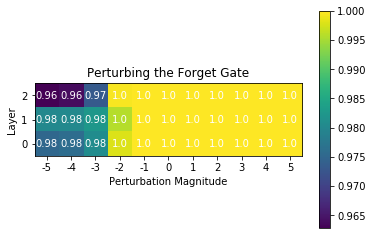

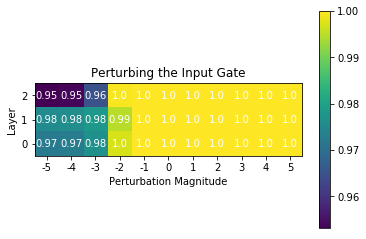

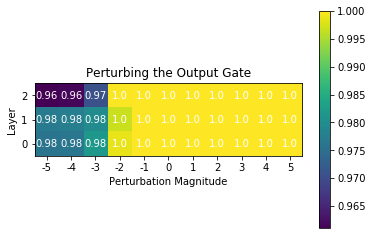

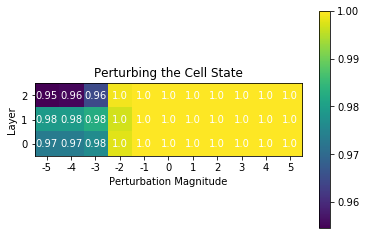

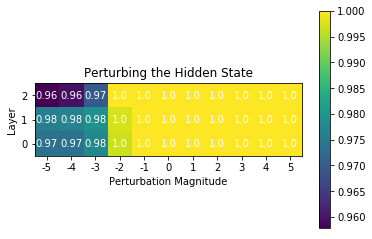

In [175]:
perturbations = [-5,-4,-3,-2,-1,0,1,2,3,4,5]


accuracies = np.zeros((3,len(perturbations)))

for pert in perturbations:
    for lyr in fmods.keys():
        cls,reg = fmods[lyr]
        
        X_train,y_train,X_test,y_test = fcls_data[lyr]
        
        correct = 0
        for idx,x in enumerate(X_test):
            true = y_test[idx]
            
            if true == 1:
                xp = np.clip(a=x + 10**pert * cls.coef_, a_min=0, a_max = 1)
            elif true == 0:
                xp = np.clip(a=x - 10**pert * cls.coef_, a_min=0, a_max = 1)
                
            
            if(cls.predict(xp.reshape(1,-1)) == true):
                correct += 1
            
        accuracy = correct / len(y_test)
        
        accuracies[lyr,5+pert] = accuracy
plt.imshow(accuracies, origin='lower', cmap='viridis')

for i in range(len(accuracies)):
    for j in range(len(accuracies[i])):
        text = plt.text(j, i, round(accuracies[i, j],2),
                       ha="center", va="center", color="w")
plt.xticks(range(11),perturbations)
plt.xlabel('Perturbation Magnitude')
plt.ylabel('Layer')
plt.title('Perturbing the Forget Gate')
plt.colorbar()
plt.show()
plt.close()


accuracies = np.zeros((3,len(perturbations)))

for pert in perturbations:
    for lyr in imods.keys():
        cls,reg = imods[lyr]
        
        X_train,y_train,X_test,y_test = icls_data[lyr]
        
        correct = 0
        for idx,x in enumerate(X_test):
            true = y_test[idx]
            
            if true == 1:
                xp = np.clip(a=x + 10**pert * cls.coef_, a_min=0, a_max = 1)
            elif true == 0:
                xp = np.clip(a=x - 10**pert * cls.coef_, a_min=0, a_max = 1)
                
            
            if(cls.predict(xp.reshape(1,-1)) == true):
                correct += 1
            
        accuracy = correct / len(y_test)
        
        accuracies[lyr,5+pert] = accuracy
plt.imshow(accuracies, origin='lower', cmap='viridis')

for i in range(len(accuracies)):
    for j in range(len(accuracies[i])):
        text = plt.text(j, i, round(accuracies[i, j],2),
                       ha="center", va="center", color="w")
plt.xticks(range(11),perturbations)
plt.xlabel('Perturbation Magnitude')
plt.ylabel('Layer')
plt.title('Perturbing the Input Gate')
plt.colorbar()
plt.show()
plt.close()


# output gate
accuracies = np.zeros((3,len(perturbations)))

for pert in perturbations:
    for lyr in omods.keys():
        cls,reg = omods[lyr]
        
        X_train,y_train,X_test,y_test = ocls_data[lyr]
        
        correct = 0
        for idx,x in enumerate(X_test):
            true = y_test[idx]
            
            if true == 1:
                xp = np.clip(a=x + 10**pert * cls.coef_, a_min=0, a_max = 1)
            elif true == 0:
                xp = np.clip(a=x - 10**pert * cls.coef_, a_min=0, a_max = 1)
                
            
            if(cls.predict(xp.reshape(1,-1)) == true):
                correct += 1
            
        accuracy = correct / len(y_test)
        
        accuracies[lyr,5+pert] = accuracy
plt.imshow(accuracies, origin='lower', cmap='viridis')

for i in range(len(accuracies)):
    for j in range(len(accuracies[i])):
        text = plt.text(j, i, round(accuracies[i, j],2),
                       ha="center", va="center", color="w")
plt.xticks(range(11),perturbations)
plt.xlabel('Perturbation Magnitude')
plt.ylabel('Layer')
plt.title('Perturbing the Output Gate')
plt.colorbar()
plt.show()
plt.close()


# cell state
accuracies = np.zeros((3,len(perturbations)))

for pert in perturbations:
    for lyr in cmods.keys():
        cls,reg = cmods[lyr]
        
        X_train,y_train,X_test,y_test = ccls_data[lyr]
        
        correct = 0
        for idx,x in enumerate(X_test):
            true = y_test[idx]
            
            if true == 1:
                xp = np.clip(a=x + 10**pert * cls.coef_, a_min=0, a_max = 1)
            elif true == 0:
                xp = np.clip(a=x - 10**pert * cls.coef_, a_min=0, a_max = 1)
                
            
            if(cls.predict(xp.reshape(1,-1)) == true):
                correct += 1
            
        accuracy = correct / len(y_test)
        
        accuracies[lyr,5+pert] = accuracy
plt.imshow(accuracies, origin='lower', cmap='viridis')

for i in range(len(accuracies)):
    for j in range(len(accuracies[i])):
        text = plt.text(j, i, round(accuracies[i, j],2),
                       ha="center", va="center", color="w")
plt.xticks(range(11),perturbations)
plt.xlabel('Perturbation Magnitude')
plt.ylabel('Layer')
plt.title('Perturbing the Cell State')
plt.colorbar()
plt.show()
plt.close()


# hidden state
accuracies = np.zeros((3,len(perturbations)))

for pert in perturbations:
    for lyr in fmods.keys():
        cls,reg = hmods[lyr]
        
        X_train,y_train,X_test,y_test = hcls_data[lyr]
        
        correct = 0
        for idx,x in enumerate(X_test):
            true = y_test[idx]
            
            if true == 1:
                xp = np.clip(a=x + 10**pert * cls.coef_, a_min=0, a_max = 1)
            elif true == 0:
                xp = np.clip(a=x - 10**pert * cls.coef_, a_min=0, a_max = 1)
                
            
            if(cls.predict(xp.reshape(1,-1)) == true):
                correct += 1
            
        accuracy = correct / len(y_test)
        
        accuracies[lyr,5+pert] = accuracy
plt.imshow(accuracies, origin='lower', cmap='viridis')

for i in range(len(accuracies)):
    for j in range(len(accuracies[i])):
        text = plt.text(j, i, round(accuracies[i, j],2),
                       ha="center", va="center", color="w")
plt.xticks(range(11),perturbations)
plt.xlabel('Perturbation Magnitude')
plt.ylabel('Layer')
plt.title('Perturbing the Hidden State')
plt.colorbar()
plt.show()
plt.close()

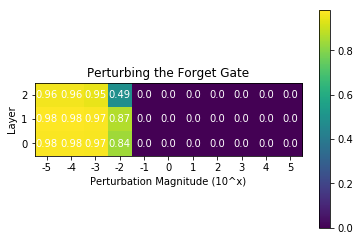

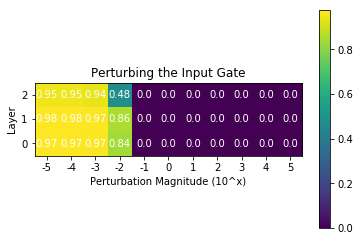

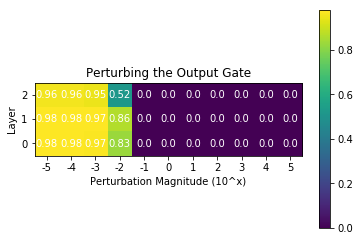

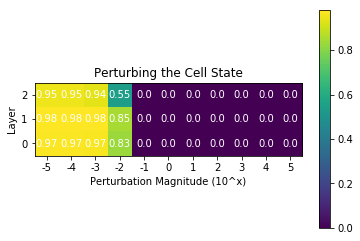

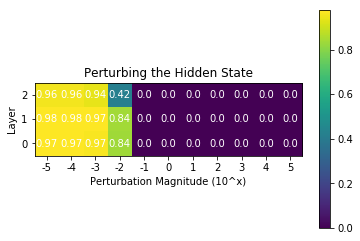

In [177]:
perturbations = [-5,-4,-3,-2,-1,0,1,2,3,4,5]


accuracies = np.zeros((3,len(perturbations)))

for pert in perturbations:
    for lyr in fmods.keys():
        cls,reg = fmods[lyr]
        
        X_train,y_train,X_test,y_test = fcls_data[lyr]
        
        correct = 0
        for idx,x in enumerate(X_test):
            true = y_test[idx]
            
            if true == 1:
                xp = np.clip(a=x - 10**pert * cls.coef_, a_min=0, a_max = 1)
            elif true == 0:
                xp = np.clip(a=x + 10**pert * cls.coef_, a_min=0, a_max = 1)
                
            
            if(cls.predict(xp.reshape(1,-1)) == true):
                correct += 1
            
        accuracy = correct / len(y_test)
        
        accuracies[lyr,5+pert] = accuracy
plt.imshow(accuracies, origin='lower', cmap='viridis')

for i in range(len(accuracies)):
    for j in range(len(accuracies[i])):
        text = plt.text(j, i, round(accuracies[i, j],2),
                       ha="center", va="center", color="w")
plt.xticks(range(11),perturbations)
plt.xlabel('Perturbation Magnitude (10^x)')
plt.ylabel('Layer')
plt.title('Perturbing the Forget Gate')
plt.colorbar()
plt.show()
plt.close()


accuracies = np.zeros((3,len(perturbations)))

for pert in perturbations:
    for lyr in imods.keys():
        cls,reg = imods[lyr]
        
        X_train,y_train,X_test,y_test = icls_data[lyr]
        
        correct = 0
        for idx,x in enumerate(X_test):
            true = y_test[idx]
            
            if true == 1:
                xp = np.clip(a=x - 10**pert * cls.coef_, a_min=0, a_max = 1)
            elif true == 0:
                xp = np.clip(a=x + 10**pert * cls.coef_, a_min=0, a_max = 1)
                
            
            if(cls.predict(xp.reshape(1,-1)) == true):
                correct += 1
            
        accuracy = correct / len(y_test)
        
        accuracies[lyr,5+pert] = accuracy
plt.imshow(accuracies, origin='lower', cmap='viridis')

for i in range(len(accuracies)):
    for j in range(len(accuracies[i])):
        text = plt.text(j, i, round(accuracies[i, j],2),
                       ha="center", va="center", color="w")
plt.xticks(range(11),perturbations)
plt.xlabel('Perturbation Magnitude (10^x)')
plt.ylabel('Layer')
plt.title('Perturbing the Input Gate')
plt.colorbar()
plt.show()
plt.close()


# output gate
accuracies = np.zeros((3,len(perturbations)))

for pert in perturbations:
    for lyr in omods.keys():
        cls,reg = omods[lyr]
        
        X_train,y_train,X_test,y_test = ocls_data[lyr]
        
        correct = 0
        for idx,x in enumerate(X_test):
            true = y_test[idx]
            
            if true == 1:
                xp = np.clip(a=x - 10**pert * cls.coef_, a_min=0, a_max = 1)
            elif true == 0:
                xp = np.clip(a=x + 10**pert * cls.coef_, a_min=0, a_max = 1)
                
            
            if(cls.predict(xp.reshape(1,-1)) == true):
                correct += 1
            
        accuracy = correct / len(y_test)
        
        accuracies[lyr,5+pert] = accuracy
plt.imshow(accuracies, origin='lower', cmap='viridis')

for i in range(len(accuracies)):
    for j in range(len(accuracies[i])):
        text = plt.text(j, i, round(accuracies[i, j],2),
                       ha="center", va="center", color="w")
plt.xticks(range(11),perturbations)
plt.xlabel('Perturbation Magnitude (10^x)')
plt.ylabel('Layer')
plt.title('Perturbing the Output Gate')
plt.colorbar()
plt.show()
plt.close()


# cell state
accuracies = np.zeros((3,len(perturbations)))

for pert in perturbations:
    for lyr in cmods.keys():
        cls,reg = cmods[lyr]
        
        X_train,y_train,X_test,y_test = ccls_data[lyr]
        
        correct = 0
        for idx,x in enumerate(X_test):
            true = y_test[idx]
            
            if true == 1:
                xp = np.clip(a=x - 10**pert * cls.coef_, a_min=0, a_max = 1)
            elif true == 0:
                xp = np.clip(a=x + 10**pert * cls.coef_, a_min=0, a_max = 1)
                
            
            if(cls.predict(xp.reshape(1,-1)) == true):
                correct += 1
            
        accuracy = correct / len(y_test)
        
        accuracies[lyr,5+pert] = accuracy
plt.imshow(accuracies, origin='lower', cmap='viridis')

for i in range(len(accuracies)):
    for j in range(len(accuracies[i])):
        text = plt.text(j, i, round(accuracies[i, j],2),
                       ha="center", va="center", color="w")
plt.xticks(range(11),perturbations)
plt.xlabel('Perturbation Magnitude (10^x)')
plt.ylabel('Layer')
plt.title('Perturbing the Cell State')
plt.colorbar()
plt.show()
plt.close()


# hidden state
accuracies = np.zeros((3,len(perturbations)))

for pert in perturbations:
    for lyr in fmods.keys():
        cls,reg = hmods[lyr]
        
        X_train,y_train,X_test,y_test = hcls_data[lyr]
        
        correct = 0
        for idx,x in enumerate(X_test):
            true = y_test[idx]
            
            if true == 1:
                xp = np.clip(a=x - 10**pert * cls.coef_, a_min=0, a_max = 1)
            elif true == 0:
                xp = np.clip(a=x + 10**pert * cls.coef_, a_min=0, a_max = 1)
                
            
            if(cls.predict(xp.reshape(1,-1)) == true):
                correct += 1
            
        accuracy = correct / len(y_test)
        
        accuracies[lyr,5+pert] = accuracy
plt.imshow(accuracies, origin='lower', cmap='viridis')

for i in range(len(accuracies)):
    for j in range(len(accuracies[i])):
        text = plt.text(j, i, round(accuracies[i, j],2),
                       ha="center", va="center", color="w")
plt.xticks(range(11),perturbations)
plt.xlabel('Perturbation Magnitude (10^x)')
plt.ylabel('Layer')
plt.title('Perturbing the Hidden State')
plt.colorbar()
plt.show()
plt.close()

In [147]:
offset = 0

forget_class_targets = get_class_targets(forget_gates,offset=offset)
forget_regrs_targets = get_regrs_targets(forget_gates,offset=offset)

input_class_targets = get_class_targets(input_gates,offset=offset)
input_regrs_targets = get_regrs_targets(input_gates,offset=offset)

output_class_targets = get_class_targets(output_gates,offset=offset)
output_regrs_targets = get_regrs_targets(output_gates,offset=offset)

cell_class_targets = get_class_targets(cell_states,offset=offset)
cell_regrs_targets = get_regrs_targets(cell_states,offset=offset)

hidden_class_targets = get_class_targets(hidden_states,offset=offset)
hidden_regrs_targets = get_regrs_targets(hidden_states,offset=offset)

print('\nFORGET')
fmods,fcls_data,freg_data = model_evaluation(forget_class_targets,forget_regrs_targets,krnl='rbf')

print('\nINPUT')
imods,icls_data,ireg_data = model_evaluation(input_class_targets,input_regrs_targets,krnl='rbf')

print('\nOUTPUT')
omods,ocls_data,oreg_data = model_evaluation(output_class_targets,output_regrs_targets,krnl='rbf')

print('\nCELL')
cmods,ccls_data,creg_data = model_evaluation(cell_class_targets,cell_regrs_targets,krnl='rbf')

print('\nHIDDEN')
hmods,hcls_data,hreg_data = model_evaluation(hidden_class_targets,hidden_regrs_targets,krnl='rbf')


FORGET
Layer 0
CLASSIFICATION
Training Percent 0.2
C 1
Acc 0.8445078459343794
REGRESSION
Training Percent 0.2
C 1
R^2 0.8080753259815356
Layer 1
CLASSIFICATION
Training Percent 0.2
C 1
Acc 0.8927382650635147
REGRESSION
Training Percent 0.2
C 1
R^2 0.8524668175139838
Layer 2
CLASSIFICATION
Training Percent 0.2
C 1
Acc 0.8547653012702942
REGRESSION
Training Percent 0.2
C 1
R^2 0.8053698179431756

INPUT
Layer 0
CLASSIFICATION
Training Percent 0.2
C 1
Acc 0.8412471978805788
REGRESSION
Training Percent 0.2
C 1
R^2 0.8066964259613657
Layer 1
CLASSIFICATION
Training Percent 0.2
C 1
Acc 0.8813259968752123
REGRESSION
Training Percent 0.2
C 1
R^2 0.8505117529068337
Layer 2
CLASSIFICATION
Training Percent 0.2
C 1
Acc 0.8595883431832076
REGRESSION
Training Percent 0.2
C 1
R^2 0.8128280517258814

OUTPUT
Layer 0
CLASSIFICATION
Training Percent 0.2
C 1
Acc 0.8417906392228789
REGRESSION
Training Percent 0.2
C 1
R^2 0.8088370863467851
Layer 1
CLASSIFICATION
Training Percent 0.2
C 1
Acc 0.8898172678486

In [ ]:
# modifiying by classifier...
for lam in [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]:
    print('\n\n\nMODIFYING BY THE CLASSIFIER WITH LAMBDA =',lam)
    for lyr in model_pairs.keys():
        print('\n\nLayer ',lyr+1)
        print('===================================================')
        clsf,reg = model_pairs[lyr]
        (cX_train,cy_train,cX_test,cy_test) = clsf_data[lyr]
        (rX_train,ry_train,rX_test,ry_test) = reg_data[lyr]

        w = clsf.coef_

        ncX_test = np.clip(cX_test - lam*w,0,1)
        nrX_test = np.clip(rX_test - lam*w,0,1)
        ncX_train = np.clip(cX_train - lam*w,0,1)
        nrX_train = np.clip(rX_train - lam*w,0,1)

        pcX_test = np.clip(cX_test + lam*w,0,1)
        prX_test = np.clip(rX_test + lam*w,0,1)
        pcX_train = np.clip(cX_train + lam*w,0,1)
        prX_train = np.clip(rX_train + lam*w,0,1)


        print('\nTesting Classifier Modifying the Classifier Dataset')
        print('Classifier on Test Set - ',clsf.score(cX_test,cy_test))
        print('Classifier on Training Set - ',clsf.score(cX_train,cy_train)) 
        print('\nDecrease on Classifier Test Set - ',clsf.score(ncX_test,cy_test))
        print('Increase on Classifier Test Set - ',clsf.score(pcX_test,cy_test))
        print('Decrease on Classifier Training Set - ',clsf.score(ncX_train,cy_train))
        print('Increase on Classifier Training Set - ',clsf.score(pcX_train,cy_train))



        print('\nTesting Regressor Modifying the Regression Dataset')
        ypred = reg.predict(rX_test)
        print('Regressor on Test Set - ',skm.mean_squared_error(ry_test,ypred))
        ypred = reg.predict(rX_train)
        print('Regressor on Training Set - ',skm.mean_squared_error(ry_train,ypred))

        ypred = reg.predict(nrX_test)
        print('\nDecrease on Regressor Test Set - ',skm.mean_squared_error(ry_test,ypred))
        ypred = reg.predict(prX_test)
        print('Increase on Regressor Test Set - ',skm.mean_squared_error(ry_test,ypred))

        ypred = reg.predict(nrX_train)
        print('Decrease on Regressor Training Set - ',skm.mean_squared_error(ry_train,ypred))
        ypred = reg.predict(prX_train)
        print('Increase on Regressor Training Set - ',skm.mean_squared_error(ry_train,ypred))


In [126]:
# modifiying by Regressor...

for lam in [0.001,0.01,0.1,1,10,100,1000]:
    print('MODIFYING BY THE REGRESSOR WITH LAMBDA =',lam)
    for lyr in model_pairs.keys():
        print('\n\nLayer ',lyr+1)
        print('===================================================')
        clsf,reg = model_pairs[lyr]
        (cX_train,cy_train,cX_test,cy_test) = clsf_data[lyr]
        (rX_train,ry_train,rX_test,ry_test) = reg_data[lyr]

        w = reg.coef_

        ncX_test = cX_test - lam*w
        nrX_test = rX_test - lam*w
        ncX_train = cX_train - lam*w
        nrX_train = rX_train - lam*w

        pcX_test = cX_test + lam*w
        prX_test = rX_test + lam*w
        pcX_train = cX_train + lam*w
        prX_train = rX_train + lam*w


        print('\nTesting Classifier Modifying the Classifier Dataset')
        print('Classifier on Test Set - ',clsf.score(cX_test,cy_test))
        print('Classifier on Training Set - ',clsf.score(cX_train,cy_train)) 
        print('\nDecrease on Classifier Test Set - ',clsf.score(ncX_test,cy_test))
        print('Increase on Classifier Test Set - ',clsf.score(pcX_test,cy_test))
        print('Decrease on Classifier Training Set - ',clsf.score(ncX_train,cy_train))
        print('Increase on Classifier Training Set - ',clsf.score(pcX_train,cy_train))



        print('\nTesting Regressor Modifying the Regression Dataset')
        ypred = reg.predict(rX_test)
        print('Regressor on Test Set - ',skm.mean_squared_error(ry_test,ypred))
        ypred = reg.predict(rX_train)
        print('Regressor on Training Set - ',skm.mean_squared_error(ry_train,ypred))

        ypred = reg.predict(nrX_test)
        print('\nDecrease on Regressor Test Set - ',skm.mean_squared_error(ry_test,ypred))
        ypred = reg.predict(prX_test)
        print('Increase on Regressor Test Set - ',skm.mean_squared_error(ry_test,ypred))

        ypred = reg.predict(nrX_train)
        print('Decrease on Regressor Training Set - ',skm.mean_squared_error(ry_train,ypred))
        ypred = reg.predict(prX_train)
        print('Increase on Regressor Training Set - ',skm.mean_squared_error(ry_train,ypred))



MODIFYING BY THE REGRESSOR WITH LAMBDA = 0.001


Layer  1

Testing Classifier Modifying the Classifier Dataset
Classifier on Test Set -  0.9777189049656952
Classifier on Training Set -  0.9858657243816255

Decrease on Classifier Test Set -  0.9776509747979077
Increase on Classifier Test Set -  0.9777868351334827
Decrease on Classifier Training Set -  0.9855939113889643
Increase on Classifier Training Set -  0.9864093503669475

Testing Regressor Modifying the Regression Dataset
Regressor on Test Set -  1.1230902016389335
Regressor on Training Set -  0.7515953359168852

Decrease on Regressor Test Set -  1.4682530289970868
Increase on Regressor Test Set -  1.4911596596134764
Decrease on Regressor Training Set -  1.1081981249466075
Increase on Regressor Training Set -  1.108224850692417


Layer  2

Testing Classifier Modifying the Classifier Dataset
Classifier on Test Set -  0.9707220976835813
Classifier on Training Set -  0.9934764881761348

Decrease on Classifier Test Set -  0.9709258881


Testing Classifier Modifying the Classifier Dataset
Classifier on Test Set -  0.9707220976835813
Classifier on Training Set -  0.9934764881761348

Decrease on Classifier Test Set -  0.19842402010732965
Increase on Classifier Test Set -  0.8015759798926704
Decrease on Classifier Training Set -  0.19842348464256593
Increase on Classifier Training Set -  0.8015765153574341

Testing Regressor Modifying the Regression Dataset
Regressor on Test Set -  0.8605322857752432
Regressor on Training Set -  0.480957025021918

Decrease on Regressor Test Set -  99123.1263647163
Increase on Regressor Test Set -  99138.23691757391
Decrease on Regressor Training Set -  99130.3079807175
Increase on Regressor Training Set -  99130.29594637503


Layer  3

Testing Classifier Modifying the Classifier Dataset
Classifier on Test Set -  0.955098159092453
Classifier on Training Set -  0.9709160097852677

Decrease on Classifier Test Set -  0.19842402010732965
Increase on Classifier Test Set -  0.8015759798926704
D

Classifier on Training Set -  0.9709160097852677

Decrease on Classifier Test Set -  0.19842402010732965
Increase on Classifier Test Set -  0.8015759798926704
Decrease on Classifier Training Set -  0.19842348464256593
Increase on Classifier Training Set -  0.8015765153574341

Testing Regressor Modifying the Regression Dataset
Regressor on Test Set -  1.093162140904647
Regressor on Training Set -  0.9393539651789746

Decrease on Regressor Test Set -  53891381939.69832
Increase on Regressor Test Set -  53891384298.740295
Decrease on Regressor Training Set -  53891385921.14328
Increase on Regressor Training Set -  53891380340.72996


In [131]:
model_pairs = {}
clsf_data = {}
reg_data = {}

for lyr in forget_targets:
    print('Layer',lyr)
    x_class,y_class = forget_class_targets__1[lyr]
    print('CLASSIFICATION')
    (csf,X_train,y_train,X_test,y_test) = classifier_finder(x_class,y_class,penalization=[1],train_percent=[0.2])[0]
    clsf_data[lyr] = (X_train,y_train,X_test,y_test)
    
    x_reg,y_reg = forget_regrs_targets__1[lyr]
    print('REGRESSION')
    (reg,X_train,y_train,X_test,y_test) = regressor_finder(gates=x_reg,targets=y_reg,class_targets=y_class,penalization=[1],train_percent=[0.2])[0]
    reg_data[lyr] = (X_train,y_train,X_test,y_test)
    
    model_pairs[lyr] = (csf,reg)
    

Layer 0
CLASSIFICATION
Training Percent 0.2
C 1
Acc 0.9044222539229672
REGRESSION
Training Percent 0.2
C 1
R^2 0.6658458900571531
Layer 1
CLASSIFICATION
Training Percent 0.2
C 1
Acc 0.9233068405678962
REGRESSION
Training Percent 0.2
C 1
R^2 0.711530071199724
Layer 2
CLASSIFICATION
Training Percent 0.2
C 1
Acc 0.920114122681883
REGRESSION
Training Percent 0.2
C 1
R^2 0.66665074001736


In [132]:
# modifiying by classifier...
for lam in [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]:
    print('\n\n\nMODIFYING BY THE CLASSIFIER WITH LAMBDA =',lam)
    for lyr in model_pairs.keys():
        print('\n\nLayer ',lyr+1)
        print('===================================================')
        clsf,reg = model_pairs[lyr]
        (cX_train,cy_train,cX_test,cy_test) = clsf_data[lyr]
        (rX_train,ry_train,rX_test,ry_test) = reg_data[lyr]

        w = clsf.coef_

        ncX_test = np.clip(cX_test - lam*w,0,1)
        nrX_test = np.clip(rX_test - lam*w,0,1)
        ncX_train = np.clip(cX_train - lam*w,0,1)
        nrX_train = np.clip(rX_train - lam*w,0,1)

        pcX_test = np.clip(cX_test + lam*w,0,1)
        prX_test = np.clip(rX_test + lam*w,0,1)
        pcX_train = np.clip(cX_train + lam*w,0,1)
        prX_train = np.clip(rX_train + lam*w,0,1)


        print('\nTesting Classifier Modifying the Classifier Dataset')
        print('Classifier on Test Set - ',clsf.score(cX_test,cy_test))
        print('Classifier on Training Set - ',clsf.score(cX_train,cy_train)) 
        print('\nDecrease on Classifier Test Set - ',clsf.score(ncX_test,cy_test))
        print('Increase on Classifier Test Set - ',clsf.score(pcX_test,cy_test))
        print('Decrease on Classifier Training Set - ',clsf.score(ncX_train,cy_train))
        print('Increase on Classifier Training Set - ',clsf.score(pcX_train,cy_train))



        print('\nTesting Regressor Modifying the Regression Dataset')
        ypred = reg.predict(rX_test)
        print('Regressor on Test Set - ',skm.mean_squared_error(ry_test,ypred))
        ypred = reg.predict(rX_train)
        print('Regressor on Training Set - ',skm.mean_squared_error(ry_train,ypred))

        ypred = reg.predict(nrX_test)
        print('\nDecrease on Regressor Test Set - ',skm.mean_squared_error(ry_test,ypred))
        ypred = reg.predict(prX_test)
        print('Increase on Regressor Test Set - ',skm.mean_squared_error(ry_test,ypred))

        ypred = reg.predict(nrX_train)
        print('Decrease on Regressor Training Set - ',skm.mean_squared_error(ry_train,ypred))
        ypred = reg.predict(prX_train)
        print('Increase on Regressor Training Set - ',skm.mean_squared_error(ry_train,ypred))






MODIFYING BY THE CLASSIFIER WITH LAMBDA = 1e-06


Layer  1

Testing Classifier Modifying the Classifier Dataset
Classifier on Test Set -  0.9044222539229672
Classifier on Training Set -  0.928241369937483

Decrease on Classifier Test Set -  0.9044222539229672
Increase on Classifier Test Set -  0.9044222539229672
Decrease on Classifier Training Set -  0.928241369937483
Increase on Classifier Training Set -  0.928241369937483

Testing Regressor Modifying the Regression Dataset
Regressor on Test Set -  1.9550890350580474
Regressor on Training Set -  1.232208808283796

Decrease on Regressor Test Set -  1.9550897229734234
Increase on Regressor Test Set -  1.955088483171808
Decrease on Regressor Training Set -  1.2322089716398013
Increase on Regressor Training Set -  1.2322089725211622


Layer  2

Testing Classifier Modifying the Classifier Dataset
Classifier on Test Set -  0.9233068405678962
Classifier on Training Set -  0.9646643109540636

Decrease on Classifier Test Set -  0.9233747707


Testing Classifier Modifying the Classifier Dataset
Classifier on Test Set -  0.9233068405678962
Classifier on Training Set -  0.9646643109540636

Decrease on Classifier Test Set -  0.9281978126485972
Increase on Classifier Test Set -  0.9146117790910944
Decrease on Classifier Training Set -  0.9717314487632509
Increase on Classifier Training Set -  0.9586844251155205

Testing Regressor Modifying the Regression Dataset
Regressor on Test Set -  1.6928343644069777
Regressor on Training Set -  0.8928241477087605

Decrease on Regressor Test Set -  1.6940588063244633
Increase on Regressor Test Set -  1.695449231675806
Decrease on Regressor Training Set -  0.8947414741476837
Increase on Regressor Training Set -  0.8947457602414559


Layer  3

Testing Classifier Modifying the Classifier Dataset
Classifier on Test Set -  0.920114122681883
Classifier on Training Set -  0.9442783365044849

Decrease on Classifier Test Set -  0.9296922763399226
Increase on Classifier Test Set -  0.911554921540656

Classifier on Training Set -  0.9442783365044849

Decrease on Classifier Test Set -  0.8015759798926704
Increase on Classifier Test Set -  0.19842402010732965
Decrease on Classifier Training Set -  0.8015765153574341
Increase on Classifier Training Set -  0.19842348464256593

Testing Regressor Modifying the Regression Dataset
Regressor on Test Set -  1.9581950586466985
Regressor on Training Set -  1.5399513732189212

Decrease on Regressor Test Set -  84.57686202519021
Increase on Regressor Test Set -  119.42142659833544
Decrease on Regressor Training Set -  84.08065306244367
Increase on Regressor Training Set -  119.5986781933882



MODIFYING BY THE CLASSIFIER WITH LAMBDA = 10


Layer  1

Testing Classifier Modifying the Classifier Dataset
Classifier on Test Set -  0.9044222539229672
Classifier on Training Set -  0.928241369937483

Decrease on Classifier Test Set -  0.8015759798926704
Increase on Classifier Test Set -  0.19842402010732965
Decrease on Classifier Training Set -  0.801576

In [133]:
# modifiying by Regressor...
for lam in [0.001,0.01,0.1,1,10,100,1000]:
    print('MODIFYING BY THE REGRESSOR WITH LAMBDA =',lam)
    for lyr in model_pairs.keys():
        print('\n\nLayer ',lyr+1)
        print('===================================================')
        clsf,reg = model_pairs[lyr]
        (cX_train,cy_train,cX_test,cy_test) = clsf_data[lyr]
        (rX_train,ry_train,rX_test,ry_test) = reg_data[lyr]

        w = reg.coef_

        ncX_test = cX_test - lam*w
        nrX_test = rX_test - lam*w
        ncX_train = cX_train - lam*w
        nrX_train = rX_train - lam*w

        pcX_test = cX_test + lam*w
        prX_test = rX_test + lam*w
        pcX_train = cX_train + lam*w
        prX_train = rX_train + lam*w


        print('\nTesting Classifier Modifying the Classifier Dataset')
        print('Classifier on Test Set - ',clsf.score(cX_test,cy_test))
        print('Classifier on Training Set - ',clsf.score(cX_train,cy_train)) 
        print('\nDecrease on Classifier Test Set - ',clsf.score(ncX_test,cy_test))
        print('Increase on Classifier Test Set - ',clsf.score(pcX_test,cy_test))
        print('Decrease on Classifier Training Set - ',clsf.score(ncX_train,cy_train))
        print('Increase on Classifier Training Set - ',clsf.score(pcX_train,cy_train))



        print('\nTesting Regressor Modifying the Regression Dataset')
        ypred = reg.predict(rX_test)
        print('Regressor on Test Set - ',skm.mean_squared_error(ry_test,ypred))
        ypred = reg.predict(rX_train)
        print('Regressor on Training Set - ',skm.mean_squared_error(ry_train,ypred))

        ypred = reg.predict(nrX_test)
        print('\nDecrease on Regressor Test Set - ',skm.mean_squared_error(ry_test,ypred))
        ypred = reg.predict(prX_test)
        print('Increase on Regressor Test Set - ',skm.mean_squared_error(ry_test,ypred))

        ypred = reg.predict(nrX_train)
        print('Decrease on Regressor Training Set - ',skm.mean_squared_error(ry_train,ypred))
        ypred = reg.predict(prX_train)
        print('Increase on Regressor Training Set - ',skm.mean_squared_error(ry_train,ypred))




MODIFYING BY THE REGRESSOR WITH LAMBDA = 0.001


Layer  1

Testing Classifier Modifying the Classifier Dataset
Classifier on Test Set -  0.9044222539229672
Classifier on Training Set -  0.928241369937483

Decrease on Classifier Test Set -  0.903878812580667
Increase on Classifier Test Set -  0.9048977650974798
Decrease on Classifier Training Set -  0.9276977439521609
Increase on Classifier Training Set -  0.9287849959228051

Testing Regressor Modifying the Regression Dataset
Regressor on Test Set -  1.9550890350580474
Regressor on Training Set -  1.232208808283796

Decrease on Regressor Test Set -  2.356215890642825
Increase on Regressor Test Set -  2.4017136008246363
Decrease on Regressor Training Set -  1.656100634848749
Increase on Regressor Training Set -  1.6560685605164454


Layer  2

Testing Classifier Modifying the Classifier Dataset
Classifier on Test Set -  0.9233068405678962
Classifier on Training Set -  0.9646643109540636

Decrease on Classifier Test Set -  0.92045377352082


Testing Classifier Modifying the Classifier Dataset
Classifier on Test Set -  0.9233068405678962
Classifier on Training Set -  0.9646643109540636

Decrease on Classifier Test Set -  0.19842402010732965
Increase on Classifier Test Set -  0.8015759798926704
Decrease on Classifier Training Set -  0.19842348464256593
Increase on Classifier Training Set -  0.8015765153574341

Testing Regressor Modifying the Regression Dataset
Regressor on Test Set -  1.6928343644069777
Regressor on Training Set -  0.8928241477087605

Decrease on Regressor Test Set -  265077.5239771224
Increase on Regressor Test Set -  265061.21044207964
Decrease on Regressor Training Set -  265068.5792474367
Increase on Regressor Training Set -  265068.5542152781


Layer  3

Testing Classifier Modifying the Classifier Dataset
Classifier on Test Set -  0.920114122681883
Classifier on Training Set -  0.9442783365044849

Decrease on Classifier Test Set -  0.19842402010732965
Increase on Classifier Test Set -  0.80157597989267

Classifier on Training Set -  0.9442783365044849

Decrease on Classifier Test Set -  0.19842402010732965
Increase on Classifier Test Set -  0.8015759798926704
Decrease on Classifier Training Set -  0.19842348464256593
Increase on Classifier Training Set -  0.8015765153574341

Testing Regressor Modifying the Regression Dataset
Regressor on Test Set -  1.9581950586466985
Regressor on Training Set -  1.5399513732189212

Decrease on Regressor Test Set -  68005704605.32965
Increase on Regressor Test Set -  68005707740.84243
Decrease on Regressor Training Set -  68005701920.71013
Increase on Regressor Training Set -  68005710355.802155


In [93]:
for lyr in forget_targets:
    print('Layer',lyr)
    x_class,y_class = forget_class_targets__1[lyr]
    print('CLASSIFICATION')
    cls = classifier_finder(x_class,y_class,penalization=[1],train_percent=[0.2])[0]
    
    x_reg,y_reg = forget_regrs_targets__1[lyr]
    print('REGRESSION')
    reg = regressor_finder(gates=x_reg,targets=y_reg,class_targets=y_class,penalization=[1],train_percent=[0.2])[0]

Layer 0
CLASSIFICATION
Training Percent 0.2
C 1
Acc 0.9044901840907547
REGRESSION
Training Percent 0.2
C 1
R^2 0.6679468176893388
Layer 1
CLASSIFICATION
Training Percent 0.2
C 1
Acc 0.9277223014740846
REGRESSION
Training Percent 0.2
C 1
R^2 0.7142749276450955
Layer 2
CLASSIFICATION
Training Percent 0.2
C 1
Acc 0.9185517288227701
REGRESSION
Training Percent 0.2
C 1
R^2 0.6711839427085436


In [94]:
cls,reg = model_pairs[1]
x_class,y_class = forget_class_targets_0[1]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091


3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754


5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395


6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046


8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691


10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
10250
10251
10252
10253
10254
10255
10256
10257
10258
10259
10260
10261
10262
10263
10264
10265
10266
10267
10268
10269
10270
10271
10272
10273
1027

11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11622
11623
11624
11625
11626
11627
11628
11629
11630
11631
11632
11633
11634
11635
11636
11637
11638
11639
11640
1164

12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
12967
12968
12969
12970
12971
12972
12973
12974
12975
12976
12977
12978
12979
12980
12981
12982
12983
12984
12985
12986
12987
12988
12989
12990
12991
12992
12993
12994
12995
12996
12997
12998
12999
13000
13001
13002
13003
13004
13005
13006
13007
13008
13009
13010
13011
13012
13013
13014
13015
1301

14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
14231
14232
14233
14234
14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346
14347
14348
14349
14350
14351
14352
14353
14354
14355
14356
14357
14358
14359
14360
14361
14362
14363
14364
14365
14366
14367
14368
14369
14370
14371
14372
14373
14374
14375
14376
14377
14378
14379
14380
14381
1438

15589
15590
15591
15592
15593
15594
15595
15596
15597
15598
15599
15600
15601
15602
15603
15604
15605
15606
15607
15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
15689
15690
15691
15692
15693
15694
15695
15696
15697
15698
15699
15700
15701
15702
15703
15704
15705
15706
15707
15708
15709
15710
15711
15712
15713
15714
15715
15716
15717
15718
15719
15720
15721
15722
15723
15724
15725
15726
15727
15728
15729
15730
15731
15732
15733
15734
15735
15736
15737
15738
15739
15740
15741
15742
15743
15744
15745
15746
15747
15748
15749
15750
15751
15752
15753
15754
1575

16957
16958
16959
16960
16961
16962
16963
16964
16965
16966
16967
16968
16969
16970
16971
16972
16973
16974
16975
16976
16977
16978
16979
16980
16981
16982
16983
16984
16985
16986
16987
16988
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
17053
17054
17055
17056
17057
17058
17059
17060
17061
17062
17063
17064
17065
17066
17067
17068
17069
17070
17071
17072
17073
17074
17075
17076
17077
17078
17079
17080
17081
17082
17083
17084
17085
17086
17087
17088
17089
17090
17091
17092
17093
17094
17095
17096
17097
17098
17099
17100
17101
17102
17103
17104
17105
17106
17107
17108
17109
17110
17111
17112
17113
17114
17115
17116
17117
17118
17119
17120
17121
17122
1712

18328
18329
18330
18331
18332
18333
18334
18335
18336
18337
18338
18339
18340
18341
18342
18343
18344
18345
18346
18347
18348
18349
18350
18351
18352
18353
18354
18355
18356
18357
18358
18359
18360
18361
18362
18363
18364
18365
18366
18367
18368
18369
18370
18371
18372
18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399


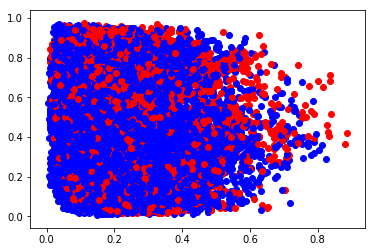

In [101]:
mean = cls.coef_.mean()
std = cls.coef_.std()

idcs = np.where(np.abs(cls.coef_) >= mean + 3*std)[1]

imp = x_class[:,idcs]

for item,lbl in enumerate(y_class):
    print(item)
    x,y = imp[item]
    if lbl == 1:
        plt.scatter(x,y,color='#FF0000')
    else:
        plt.scatter(x,y,color='#0000FF')

plt.show()
        


Focus on a small number of examples that are known to be seperated. .20 * 18000? Take all positively classified examples and move them by adding the lambda vector and negatively classified by subtracting the lambda vectors (and then do the opposite)